# LAB 6
### Жерлыгин Максим
### М8О-408Б-18

In [ ]:
import torch, torchvision
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
import copy


In [ ]:
import cv2
import numpy as np
from torchvision.datasets import VOCSegmentation

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)


VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]


class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        image,mask = torchvision.transforms.functional.to_tensor(image), torch.from_numpy(mask)
        mask = mask.permute(2,0,1)
        return image, mask

In [ ]:
from albumentations import Compose, RandomBrightnessContrast, RandomCrop, Flip, RandomSizedCrop, OneOf, PadIfNeeded

In [ ]:
augs = Compose([
                 PadIfNeeded(448,448),
                 RandomBrightnessContrast(),
                 OneOf([
                        RandomCrop(256,256, p=0.2),
                        RandomSizedCrop((224,448),256,256)
                 ], p =1)
])

In [ ]:
train_dataset = PascalVOCSearchDataset('.',download = True, transform = augs)


  0%|          | 0/1999639040 [00:00<?, ?it/s]

Extracting ./VOCtrainval_11-May-2012.tar to .


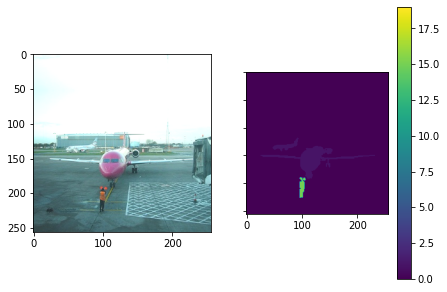

In [ ]:
img,lbl = train_dataset[0]
fig,ax = plt.subplots(1,2, sharey=True, figsize=(7,5))
ax = ax.ravel()

ax[0].imshow(img.permute(1,2,0))
lbl_plot = ax[1].imshow(lbl.argmax(0),vmax = 19)
plt.colorbar(lbl_plot,ax = ax[1])
plt.show()

In [ ]:
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

In [ ]:
model = deeplabv3_mobilenet_v3_large(True, num_classes = len(VOC_CLASSES), progress = True)

Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth


  0%|          | 0.00/42.3M [00:00<?, ?B/s]

In [ ]:
optim = torch.optim.AdamW(model.parameters(), lr = 2e-3, weight_decay = 1e-5)

In [ ]:

dataloader = DataLoader(train_dataset, batch_size = 8, shuffle = True, num_workers = 2)

In [ ]:
crit = torch.nn.CrossEntropyLoss(label_smoothing = 1e-5)

In [ ]:
model.cuda()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1),

In [13]:
test_data = PascalVOCSearchDataset('.', download = True, transform = augs, image_set = 'val')
test_dataloader = DataLoader(test_data, batch_size = 8, shuffle = True, num_workers = 2, drop_last = True)

Using downloaded and verified file: ./VOCtrainval_11-May-2012.tar
Extracting ./VOCtrainval_11-May-2012.tar to .


In [14]:
# IoU
def IoU_metric(pred, lbl):
  temp = []
  metric = []
  for sprediction, slbl in zip(pred.detach().cpu().softmax(1), lbl.detach().cpu()):
    for k in range(len(sprediction)):
      val = slbl[k]
      pred = (sprediction[k] > 0.5).float()
      inter = pred * val
      union = val + pred - inter
      if torch.sum(union) != 0:
        temp.append(float(torch.sum(inter) / torch.sum(union)))
      else:
        temp.append(-1)
    metric.append(temp)
    temp=[]
  
  return metric
  

In [16]:
# MIoU
def MIoU_metric(pred, lbl):
  iou = np.array(IoU_metric(prediction,lbl))
  result = iou[iou >= 0].mean()
  return result

In [17]:
r_losses = []
rloss = 0
best_m = 0
metrics_dict = {}
next_desc = "first epoch"

In [18]:
for epoch in range(20):
  for img,lbl in tqdm(dataloader, desc = next_desc):
    img = img.cuda()
    lbl = lbl.cuda()
    predict = model(img)['out']
    loss = crit(predict, lbl)
    loss.backward()
    optim.step()
    optim.zero_grad()
    rloss += loss.detach().cpu().item() / len(dataloader)
  r_losses += [rloss]
  next_desc = f"Epoch[{epoch+1}] | last rloss = {rloss:.3f}"
  rloss = 0
  final_MIoU = []
  for test_img, test_lbl in test_dataloader:
    test_img = test_img.cuda()
    test_lbl = test_lbl.cuda()
    prediction = model(test_img)['out']
    final_MIoU.append(MIoU_metric(prediction,test_lbl))
  if best_m < np.mean(final_MIoU):
    best_epoch = epoch
    best_model = copy.deepcopy(model)
    best_m = np.mean(final_MIoU)
  metrics_dict[epoch] = final_MIoU
  print(f'Epoch: {epoch+1} on test data MIoU = {np.mean(final_MIoU)}')

print(f'Best MIoU on {best_epoch} epoch')

first epoch: 100%|██████████| 183/183 [03:09<00:00,  1.04s/it]


Epoch: 1 on test data MIoU = 0.3028752830762301


Epoch[1] | last rloss = 1.175: 100%|██████████| 183/183 [03:12<00:00,  1.05s/it]


Epoch: 2 on test data MIoU = 0.307761436921443


Epoch[2] | last rloss = 0.957: 100%|██████████| 183/183 [03:22<00:00,  1.11s/it]


Epoch: 3 on test data MIoU = 0.30152379666250184


Epoch[3] | last rloss = 0.916: 100%|██████████| 183/183 [03:11<00:00,  1.05s/it]


Epoch: 4 on test data MIoU = 0.3137798749697414


Epoch[4] | last rloss = 0.897: 100%|██████████| 183/183 [03:07<00:00,  1.03s/it]


Epoch: 5 on test data MIoU = 0.3185517345653625


Epoch[5] | last rloss = 0.840: 100%|██████████| 183/183 [03:03<00:00,  1.00s/it]


Epoch: 6 on test data MIoU = 0.3303791968233241


Epoch[6] | last rloss = 0.780: 100%|██████████| 183/183 [03:02<00:00,  1.00it/s]


Epoch: 7 on test data MIoU = 0.32401255684303887


Epoch[7] | last rloss = 0.721: 100%|██████████| 183/183 [03:01<00:00,  1.01it/s]


Epoch: 8 on test data MIoU = 0.3503730616041667


Epoch[8] | last rloss = 0.762: 100%|██████████| 183/183 [03:00<00:00,  1.02it/s]


Epoch: 9 on test data MIoU = 0.34568843345884454


Epoch[9] | last rloss = 0.727: 100%|██████████| 183/183 [02:58<00:00,  1.03it/s]


Epoch: 10 on test data MIoU = 0.33852335856908594


Epoch[10] | last rloss = 0.680: 100%|██████████| 183/183 [02:58<00:00,  1.02it/s]


Epoch: 11 on test data MIoU = 0.3409374666414743


Epoch[11] | last rloss = 0.684: 100%|██████████| 183/183 [02:59<00:00,  1.02it/s]


Epoch: 12 on test data MIoU = 0.3482611692221657


Epoch[12] | last rloss = 0.678: 100%|██████████| 183/183 [03:01<00:00,  1.01it/s]


Epoch: 13 on test data MIoU = 0.3433341570971374


Epoch[13] | last rloss = 0.686: 100%|██████████| 183/183 [03:00<00:00,  1.01it/s]


Epoch: 14 on test data MIoU = 0.349698924935756


Epoch[14] | last rloss = 0.681: 100%|██████████| 183/183 [03:00<00:00,  1.02it/s]


Epoch: 15 on test data MIoU = 0.35704693706886


Epoch[15] | last rloss = 0.629: 100%|██████████| 183/183 [03:00<00:00,  1.01it/s]


Epoch: 16 on test data MIoU = 0.3446128510230313


Epoch[16] | last rloss = 0.577: 100%|██████████| 183/183 [03:00<00:00,  1.02it/s]


Epoch: 17 on test data MIoU = 0.359134095831973


Epoch[17] | last rloss = 0.615: 100%|██████████| 183/183 [02:59<00:00,  1.02it/s]


Epoch: 18 on test data MIoU = 0.35255688721015715


Epoch[18] | last rloss = 0.555: 100%|██████████| 183/183 [03:00<00:00,  1.02it/s]


Epoch: 19 on test data MIoU = 0.3718885384234845


Epoch[19] | last rloss = 0.568: 100%|██████████| 183/183 [03:00<00:00,  1.01it/s]


Epoch: 20 on test data MIoU = 0.37156221589587674
Best MIoU on 18 epoch


In [19]:
temp_IoU = []
for test_img,test_lbl in test_dataloader:
  test_img = test_img.cuda()
  test_lbl = test_lbl.cuda()
  prediction = model(test_img)['out']
  temp_IoU.append(IoU_metric(prediction,test_lbl))

In [20]:
metric_per_class = {}
one_metric = 0
n = 0
for i in range(21):
  for k in range(len(temp_IoU)):
    for j in range(len(temp_IoU[k])):
      if temp_IoU[k][j][i] >= 0:
        one_metric = one_metric + temp_IoU[k][j][i]
        n += 1 
  one_metric = one_metric / n
  metric_per_class[i+1] = one_metric
  one_metric = 0
  n = 0
metric_per_class

{1: 0.7649207653134331,
 2: 0.15089392698075818,
 3: 0.0,
 4: 0.15382471801482203,
 5: 0.09035383578157052,
 6: 0.010085065616294742,
 7: 0.3344831135956214,
 8: 0.2015832655204183,
 9: 0.23261651169713676,
 10: 0.0,
 11: 0.035601548965244964,
 12: 0.10819619531147517,
 13: 0.04140217252362413,
 14: 0.1103366346717238,
 15: 0.17779357363207393,
 16: 0.28050000094754596,
 17: 0.029713798447784674,
 18: 0.16197491023328384,
 19: 0.014229323690718351,
 20: 0.2906124859930962,
 21: 0.11299519535088798}

In [21]:
for i in list(metrics_dict.keys()):
  metrics_dict[i] = np.mean(metrics_dict[i])
import pandas as pd 
data_to_save = pd.DataFrame.from_dict({i:[metrics_dict[i]] for i in list(metrics_dict.keys())})
data_to_save.to_csv('logs.csv')
metric_picture = []
for test_img,test_lbl in test_dataloader:
  test_img = test_img.cuda()
  test_lbl = test_lbl.cuda()
  prediction = best_model(test_img)['out']
  metrics_per_vektor = np.array(IoU_metric(prediction,test_lbl)) 
  for k in range(len(metrics_per_vektor)):
    metric_picture.append(np.mean(metrics_per_vektor[k][metrics_per_vektor[k]>=0]))

In [22]:
k_10 = np.quantile(metric_picture, 0.1)
k_15 = np.quantile(metric_picture, 0.15)
k_25 = np.quantile(metric_picture, 0.25)
k_45 = np.quantile(metric_picture, 0.45)
k_55 = np.quantile(metric_picture, 0.55)
group_1 = []
group_2 = []
group_3 = []
class_6 = 0
class_15 = 0
class_8 = 0
best_pictures_class_6 = []
best_pictures_class_15 = []
best_pictures_class_8 = []

for test_img, test_lbl in test_dataloader:
  if len(group_1) == 2 and len(group_2) == 2 and len(group_3) == 2:
    break 
  test_img = test_img.cuda()
  test_lbl = test_lbl.cuda()
  prediction = best_model(test_img)['out']
  metrics_per_vektor = np.array(IoU_metric(prediction, test_lbl))

  for k in range(len(metrics_per_vektor)):
    actual = np.mean(metrics_per_vektor[k][metrics_per_vektor[k]>=0])
    if actual <= k_10 and len(group_1) != 2:
      group_1.append([test_img[k], prediction[k], test_lbl[k]])
      continue
    if actual >= k_15 and actual <= k_25 and len(group_2) != 2:
      group_2.append([test_img[k], prediction[k], test_lbl[k]])
      continue
    if actual >= k_45 and actual <= k_55 and len(group_3) != 2:
      group_3.append([test_img[k], prediction[k], test_lbl[k]])
      continue


def plot(group):
  img = torch.tensor([group[0][0].cpu().numpy(), group[1][0].cpu().numpy()])
  pred = torch.tensor([group[0][1].cpu().detach().numpy(), group[1][1].cpu().detach().numpy()])
  lbl = torch.tensor([group[0][2].cpu().numpy(), group[1][2].cpu().numpy()])
  fig,axes = plt.subplots(len(lbl), 3, figsize = (12, 12))

  for idc, (simg, spred, slbl) in enumerate(zip(img.detach().cpu(), pred.detach().cpu().softmax(1), lbl.detach().cpu())):
    axes[idc, 0].imshow(simg.permute(1, 2, 0))
    axes[idc, 1].imshow(spred.argmax(0), vmin = 0, vmax = len(VOC_CLASSES)-1)
    axes[idc, 2].imshow(slbl.argmax(0), vmin = 0, vmax = len(VOC_CLASSES)-1)

  [ax.get_xaxis().set_visible(False) for ax in  fig.axes]
  [ax.get_yaxis().set_visible(False) for ax in fig.axes]
  fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)


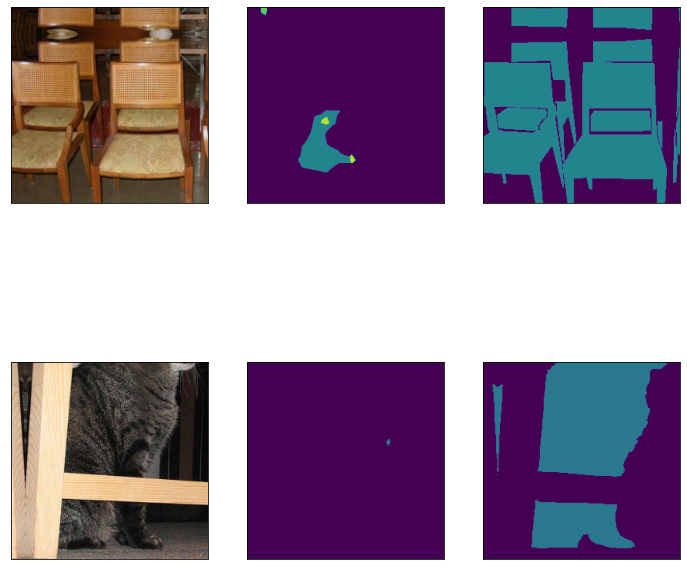

In [23]:
plot(group_1)

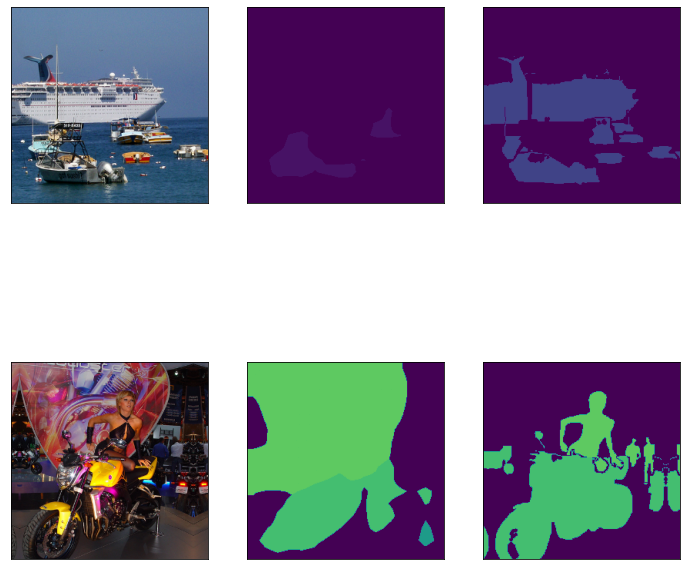

In [24]:
plot(group_2)

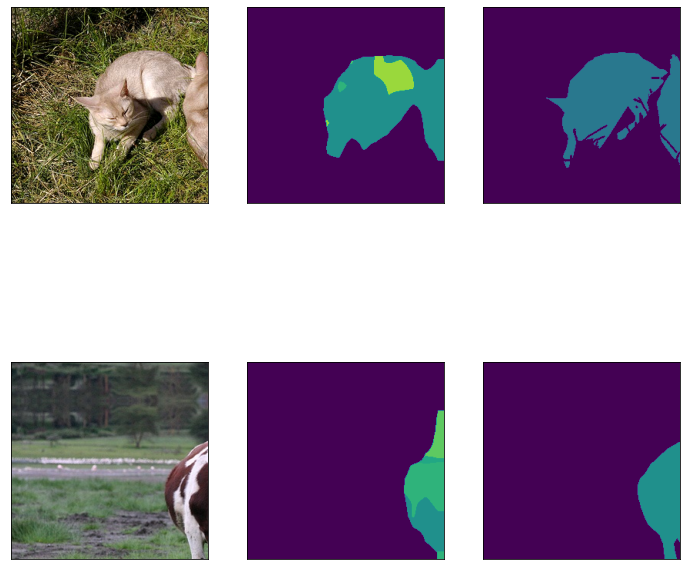

In [25]:
plot(group_3)

In [26]:
for img, lbl in test_dataloader:
  img = img.cuda()
  lbl = lbl.cuda()
  prediction = best_model(img)['out']
  metrics_vector = np.array(IoU_metric(prediction, lbl))

  for k in range(len(metrics_vector)):
    if metrics_vector[k][6] > class_6:
      class_6 = metrics_vector[k][6]
      best_pictures_class_6 = [img[k], prediction[k], lbl[k]]
    if metrics_vector[k][8] > class_8:
      class_8 = metrics_vector[k][8]
      best_pictures_class_8 = [img[k], prediction[k], lbl[k]]
    if metrics_vector[k][15] > class_15:
      class_15 = metrics_vector[k][15]
      best_pictures_class_15 = [img[k], prediction[k], lbl[k]]


def plot_2(first,second,third):
  img = torch.tensor([first[0].cpu().numpy(),second[0].cpu().numpy(),third[0].cpu().numpy()])
  predict = torch.tensor([first[1].cpu().detach().numpy(),second[1].cpu().detach().numpy(),third[1].cpu().detach().numpy()])
  lbl = torch.tensor([first[2].cpu().numpy(),second[2].cpu().numpy(),third[2].cpu().numpy()])
  fig,axes = plt.subplots(3, 3, figsize = (12, 12))

  for idc, (simg, spred, slbl) in enumerate(zip(img.detach().cpu(), predict.detach().cpu().softmax(1), lbl.detach().cpu())):
    axes[idc, 0].imshow(simg.permute(1,2,0))
    axes[idc, 1].imshow(spred.argmax(0), vmin = 0, vmax = len(VOC_CLASSES)-1)
    axes[idc, 2].imshow(slbl.argmax(0), vmin = 0, vmax = len(VOC_CLASSES)-1)
  
  [ax.get_xaxis().set_visible(False) for ax in  fig.axes]
  [ax.get_yaxis().set_visible(False) for ax in fig.axes]
  fig.show()

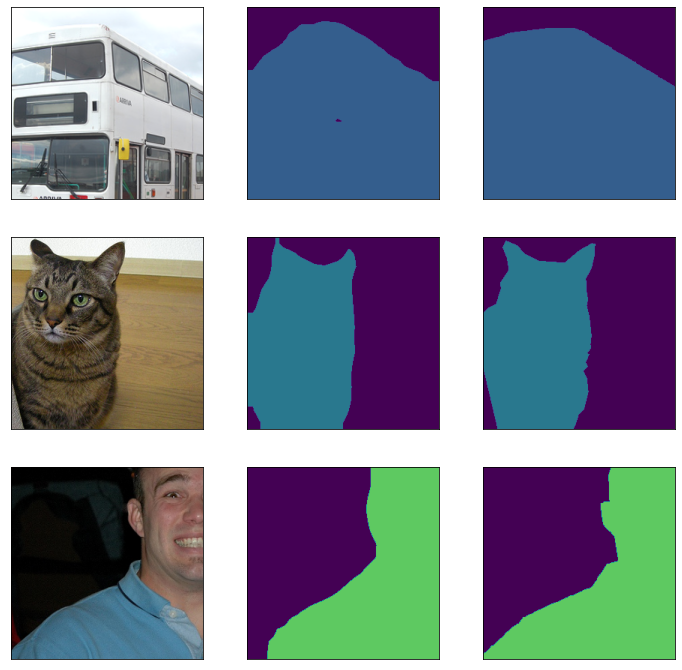

In [27]:
plot_2(best_pictures_class_6,best_pictures_class_8,best_pictures_class_15)

In [28]:
last_IoU = []
for timg, tlbl in test_dataloader:
  timg = timg.cuda()
  tlbl = tlbl.cuda()
  prediction = best_model(timg)['out']
  last_IoU.append(IoU_metric(prediction, tlbl))
  
metric_per_class = {}
one_metric  = 0
n = 0

for i in range(21):
  for k in range(len(last_IoU)):
    for j in range(len(last_IoU[k])):
      if last_IoU[k][j][i]>=0:
        one_metric = one_metric + last_IoU[k][j][i]
        n += 1 
  
  one_metric = one_metric / n
  metric_per_class[i + 1] = one_metric
  one_metric = 0
  n = 0
metric_per_class

{1: 0.7554653072194261,
 2: 0.2522944157891389,
 3: 8.161133640290549e-06,
 4: 0.08917573419646085,
 5: 0.02486150251591907,
 6: 0.0030441848354207145,
 7: 0.3180065515893276,
 8: 0.1823339415771003,
 9: 0.2059842380002846,
 10: 0.0,
 11: 0.12190234001323078,
 12: 0.1444513661476473,
 13: 0.12751399172061267,
 14: 0.02315031028232699,
 15: 0.15945794115598758,
 16: 0.2614137904479989,
 17: 0.008721453176378095,
 18: 0.16040970326834617,
 19: 0.05681703766642206,
 20: 0.2619382858396742,
 21: 0.13412671415082944}

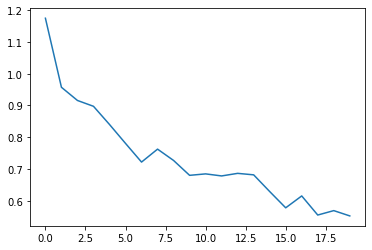

In [29]:
plt.plot(r_losses)

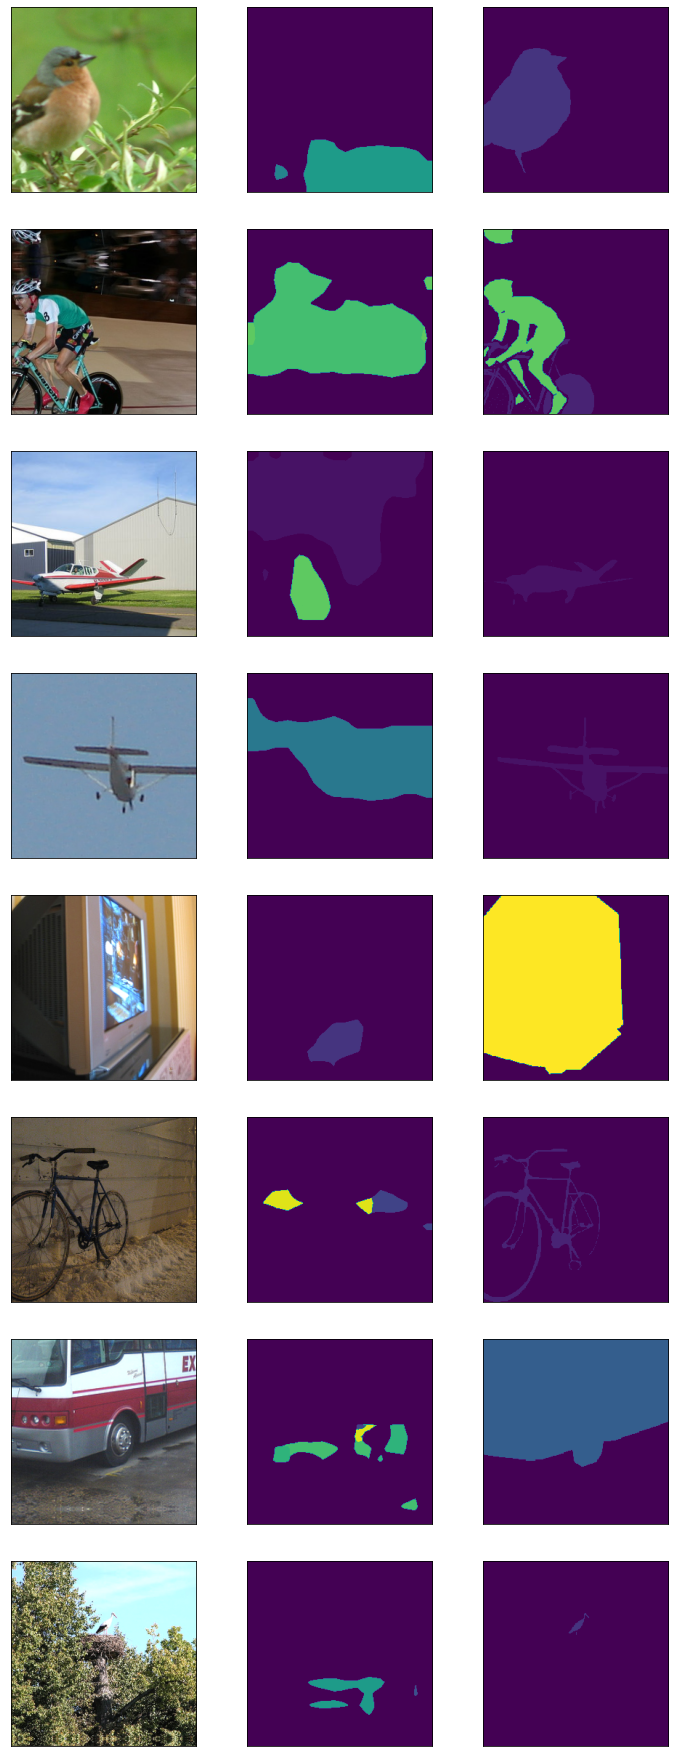

In [30]:
fig, axes = plt.subplots(len(lbl), 3, figsize = (12, len(lbl) * 4))

for idc, (simg, spred, slbl) in enumerate(zip(img.detach().cpu(), predict.detach().cpu().softmax(1), lbl.detach().cpu())):
  axes[idc, 0].imshow(simg.permute(1,2,0))
  axes[idc, 1].imshow(spred.argmax(0), vmin = 0, vmax = len(VOC_CLASSES)-1)
  axes[idc, 2].imshow(slbl.argmax(0), vmin = 0, vmax = len(VOC_CLASSES)-1)

[ax.get_xaxis().set_visible(False) for ax in  fig.axes]
[ax.get_yaxis().set_visible(False) for ax in fig.axes]
fig.show()